# Loading libraries

In [1]:
import os
import pandas as pd

# Loading Dataset

In [2]:
df = pd.read_csv(r'C:\Users\akifk\Data Science Research Project B\Data\reddit_beyondblue_combined\reddit_beyond_blue_combined.csv')

df.head()

,content
0,Do you really want to quit Xanax or are you pl...
1,My first detox and treatment center were corru...
2,"I'd stay on the Xanax long term, it's the only..."
3,"Fair enough, good for you for knowing what wil..."
4,"It’s horrible for her, but if that’s what she’..."


# GoEMotion

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm

df_goemotion = df.copy()

# Load model and tokenizer
model_name = "SamLowe/roberta-base-go_emotions"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

device = torch.device("cpu")
model.to(device)

labels = [model.config.id2label[i] for i in range(model.config.num_labels)]

# --- Function to get emotions and probabilities ---
def get_emotions_with_probs(texts, threshold=0.70):
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.sigmoid(outputs.logits).cpu().numpy()
    
    emotion_lists, prob_lists, prob_dicts = [], [], []
    for row in probs:
        detected = [labels[i] for i, p in enumerate(row) if p > threshold]
        detected_probs = [float(row[i]) for i, p in enumerate(row) if p > threshold]
        prob_dict = {f"p_{labels[i]}": float(row[i]) for i in range(len(labels))}
        emotion_lists.append(detected)
        prob_lists.append(detected_probs)
        prob_dicts.append(prob_dict)
    return emotion_lists, prob_lists, prob_dicts

# --- Batch inference ---
batch_size = 200
all_emotions, all_probs, all_dicts = [], [], []

for i in tqdm(range(0, len(df_goemotion), batch_size)):
    batch_texts = df_goemotion['content'].iloc[i:i+batch_size].astype(str).tolist()
    emotions, probs, prob_dicts = get_emotions_with_probs(batch_texts)
    all_emotions.extend(emotions)
    all_probs.extend(probs)
    all_dicts.extend(prob_dicts)

# --- Add results to df_goemotion ---
df_goemotion['emotions'] = all_emotions
df_goemotion['emotion_probs'] = all_probs

# Create prefixed probability columns
probs_df = pd.DataFrame(all_dicts)
df_goemotion = pd.concat([df_goemotion.reset_index(drop=True), probs_df.reset_index(drop=True)], axis=1)

print("✅ Done! Example columns:")
print(df_goemotion.columns[:15])


100%|██████████| 1219/1219 [2:07:36<00:00,  6.28s/it] 


✅ Done! Example columns:
Index(['content', 'emotions', 'emotion_probs', 'p_admiration', 'p_amusement',
       'p_anger', 'p_annoyance', 'p_approval', 'p_caring', 'p_confusion',
       'p_curiosity', 'p_desire', 'p_disappointment', 'p_disapproval',
       'p_disgust'],
      dtype='object')


In [4]:
df_goemotion.to_csv(r'C:\Users\akifk\Data Science Research Project B\Data\reddit_beyondblue_combined/reddit_beyondblue_combined_goEmotion.csv', index=False, encoding='utf-8')

df_goemotion.head()

,content,emotions,emotion_probs,p_admiration,p_amusement,p_anger,p_annoyance,p_approval,p_caring,p_confusion,...,p_love,p_nervousness,p_optimism,p_pride,p_realization,p_relief,p_remorse,p_sadness,p_surprise,p_neutral
0,Do you really want to quit Xanax or are you pl...,[],[],0.001410,0.000997,0.002123,0.009280,0.045078,0.040155,0.103686,...,0.002002,0.001109,0.023261,0.000125,0.006206,0.000552,0.000870,0.002155,0.001202,0.551342
1,My first detox and treatment center were corru...,[],[],0.006176,0.001056,0.001659,0.033008,0.310092,0.012487,0.003461,...,0.001541,0.007394,0.085944,0.004010,0.311169,0.017065,0.005060,0.031162,0.001922,0.291417
2,"I'd stay on the Xanax long term, it's the only...",[],[],0.001878,0.000706,0.000862,0.011092,0.091154,0.009093,0.008174,...,0.001020,0.022517,0.018610,0.000930,0.079024,0.007574,0.002018,0.040046,0.001454,0.580541
3,"Fair enough, good for you for knowing what wil...",[],[],0.135043,0.000997,0.000883,0.003624,0.513110,0.373329,0.002015,...,0.006172,0.000967,0.098792,0.003736,0.010087,0.012859,0.000897,0.001580,0.000749,0.076451
4,"It’s horrible for her, but if that’s what she’...",[],[],0.005625,0.001194,0.003273,0.013036,0.045374,0.033724,0.005522,...,0.002100,0.033958,0.014358,0.000865,0.022350,0.002991,0.002228,0.054970,0.001380,0.120210


### Removing all rows where there are no emotions labeled

In [5]:
df_goemotion_filtered = df_goemotion[df_goemotion['emotions'].apply(lambda x: len(x) > 0)]
df_goemotion_filtered = df_goemotion_filtered.reset_index(drop=True)
df_goemotion_filtered.head()

,content,emotions,emotion_probs,p_admiration,p_amusement,p_anger,p_annoyance,p_approval,p_caring,p_confusion,...,p_love,p_nervousness,p_optimism,p_pride,p_realization,p_relief,p_remorse,p_sadness,p_surprise,p_neutral
0,"not a medical professional here, but OD’s are ...",[caring],[0.9137601852416992],0.031129,0.002553,0.004117,0.007689,0.140474,0.913760,0.003660,...,0.035620,0.004811,0.150350,0.001879,0.007593,0.008546,0.006648,0.008395,0.000983,0.043379
1,I was hospitalized about a dozen times from DX...,[caring],[0.888289213180542],0.020284,0.001275,0.004293,0.007458,0.121483,0.888289,0.003638,...,0.192794,0.004332,0.061035,0.001807,0.006536,0.008767,0.007225,0.011715,0.000624,0.076625
2,"How do I know if I'm overdosing? I'm sorry, I...",[remorse],[0.7335519790649414],0.003771,0.003731,0.004624,0.010463,0.016137,0.021090,0.097616,...,0.008106,0.012870,0.007934,0.000433,0.015338,0.001873,0.733552,0.330212,0.003116,0.023700
3,"I'm sorry I shouldn't have asked that, I'll st...",[remorse],[0.7935513854026794],0.002313,0.005273,0.021682,0.036511,0.020029,0.036370,0.004292,...,0.003269,0.003623,0.018677,0.000936,0.017112,0.002486,0.793551,0.184039,0.000717,0.015916
4,"You’re not harassing me, you just need help. W...",[caring],[0.9169411659240723],0.025081,0.001426,0.006950,0.013462,0.079712,0.916941,0.003152,...,0.019579,0.005538,0.076351,0.001817,0.005540,0.007590,0.008343,0.011896,0.000757,0.041328


# GoEmotion to Ekman Mapping

In [8]:
# Official GoEmotions → Ekman mapping
ekman_map = {
    "admiration": "joy", "amusement": "joy", "anger": "anger",
    "annoyance": "anger", "approval": "joy", "caring": "joy",
    "confusion": "surprise", "curiosity": "surprise",
    "desire": "joy", "disappointment": "sadness",
    "disapproval": "disgust", "disgust": "disgust",
    "embarrassment": "sadness", "excitement": "joy",
    "fear": "fear", "gratitude": "joy", "grief": "sadness",
    "joy": "joy", "love": "joy", "nervousness": "fear",
    "optimism": "joy", "pride": "joy", "realization": "surprise",
    "relief": "joy", "remorse": "sadness", "sadness": "sadness",
    "surprise": "surprise", "neutral": "neutral"
}

# Define function to handle single/multiple/empty cases
def map_emotions_to_ekman(emotion_list):
    # handle missing or empty lists
    if not emotion_list or not isinstance(emotion_list, list):
        return []
    mapped = set()
    for emo in emotion_list:
        if emo in ekman_map:
            mapped.add(ekman_map[emo])
    return list(mapped)

# Apply the function to your column
df_goemotion_filtered["ekman_emotions"] = df_goemotion_filtered["emotions"].apply(map_emotions_to_ekman)

In [9]:
df_goemotion_ekman = df_goemotion_filtered.copy()

In [10]:
df_goemotion_ekman

,content,emotions,emotion_probs,p_admiration,p_amusement,p_anger,p_annoyance,p_approval,p_caring,p_confusion,...,p_nervousness,p_optimism,p_pride,p_realization,p_relief,p_remorse,p_sadness,p_surprise,p_neutral,ekman_emotions
0,"not a medical professional here, but OD’s are ...",[caring],[0.9137601852416992],0.031129,0.002553,0.004117,0.007689,0.140474,0.913760,0.003660,...,0.004811,0.150350,0.001879,0.007593,0.008546,0.006648,0.008395,0.000983,0.043379,[joy]
1,I was hospitalized about a dozen times from DX...,[caring],[0.888289213180542],0.020284,0.001275,0.004293,0.007458,0.121483,0.888289,0.003638,...,0.004332,0.061035,0.001807,0.006536,0.008767,0.007225,0.011715,0.000624,0.076625,[joy]
2,"How do I know if I'm overdosing? I'm sorry, I...",[remorse],[0.7335519790649414],0.003771,0.003731,0.004624,0.010463,0.016137,0.021090,0.097616,...,0.012870,0.007934,0.000433,0.015338,0.001873,0.733552,0.330212,0.003116,0.023700,[sadness]
3,"I'm sorry I shouldn't have asked that, I'll st...",[remorse],[0.7935513854026794],0.002313,0.005273,0.021682,0.036511,0.020029,0.036370,0.004292,...,0.003623,0.018677,0.000936,0.017112,0.002486,0.793551,0.184039,0.000717,0.015916,[sadness]
4,"You’re not harassing me, you just need help. W...",[caring],[0.9169411659240723],0.025081,0.001426,0.006950,0.013462,0.079712,0.916941,0.003152,...,0.005538,0.076351,0.001817,0.005540,0.007590,0.008343,0.011896,0.000757,0.041328,[joy]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98099,no idea where to post this lol. i've never tol...,[amusement],[0.7605938911437988],0.026653,0.760594,0.002727,0.015541,0.055534,0.002528,0.282469,...,0.012058,0.009853,0.003793,0.376836,0.011559,0.004496,0.005173,0.010813,0.034716,[joy]
98100,"i just graduated school, and i'm realising i n...",[fear],[0.7956265807151794],0.008737,0.005116,0.005665,0.020982,0.031845,0.010501,0.059010,...,0.387326,0.016621,0.001764,0.096656,0.007760,0.004308,0.094756,0.014161,0.025222,[fear]
98101,"i am a 12 year old girl, and have been diagnos...",[sadness],[0.7040162086486816],0.007314,0.003650,0.003192,0.012047,0.019482,0.017427,0.008421,...,0.156476,0.002162,0.001187,0.028390,0.006711,0.007630,0.704016,0.003339,0.047049,[sadness]
98102,"apparently i'm terrible at explaining myself, ...",[sadness],[0.7071269750595093],0.003877,0.002549,0.002241,0.009319,0.016168,0.012660,0.005404,...,0.022157,0.004113,0.000830,0.030746,0.003360,0.285025,0.707127,0.001593,0.025151,[sadness]


putting ekman emotions next to the content

In [11]:
df_goemotion_ekman = df_goemotion_ekman[['content', 'ekman_emotions'] + [c for c in df_goemotion.columns if c not in ['content', 'ekman_emotions']]]
df_goemotion_ekman.head()

,content,ekman_emotions,emotions,emotion_probs,p_admiration,p_amusement,p_anger,p_annoyance,p_approval,p_caring,...,p_love,p_nervousness,p_optimism,p_pride,p_realization,p_relief,p_remorse,p_sadness,p_surprise,p_neutral
0,"not a medical professional here, but OD’s are ...",[joy],[caring],[0.9137601852416992],0.031129,0.002553,0.004117,0.007689,0.140474,0.913760,...,0.035620,0.004811,0.150350,0.001879,0.007593,0.008546,0.006648,0.008395,0.000983,0.043379
1,I was hospitalized about a dozen times from DX...,[joy],[caring],[0.888289213180542],0.020284,0.001275,0.004293,0.007458,0.121483,0.888289,...,0.192794,0.004332,0.061035,0.001807,0.006536,0.008767,0.007225,0.011715,0.000624,0.076625
2,"How do I know if I'm overdosing? I'm sorry, I...",[sadness],[remorse],[0.7335519790649414],0.003771,0.003731,0.004624,0.010463,0.016137,0.021090,...,0.008106,0.012870,0.007934,0.000433,0.015338,0.001873,0.733552,0.330212,0.003116,0.023700
3,"I'm sorry I shouldn't have asked that, I'll st...",[sadness],[remorse],[0.7935513854026794],0.002313,0.005273,0.021682,0.036511,0.020029,0.036370,...,0.003269,0.003623,0.018677,0.000936,0.017112,0.002486,0.793551,0.184039,0.000717,0.015916
4,"You’re not harassing me, you just need help. W...",[joy],[caring],[0.9169411659240723],0.025081,0.001426,0.006950,0.013462,0.079712,0.916941,...,0.019579,0.005538,0.076351,0.001817,0.005540,0.007590,0.008343,0.011896,0.000757,0.041328


Visualizing

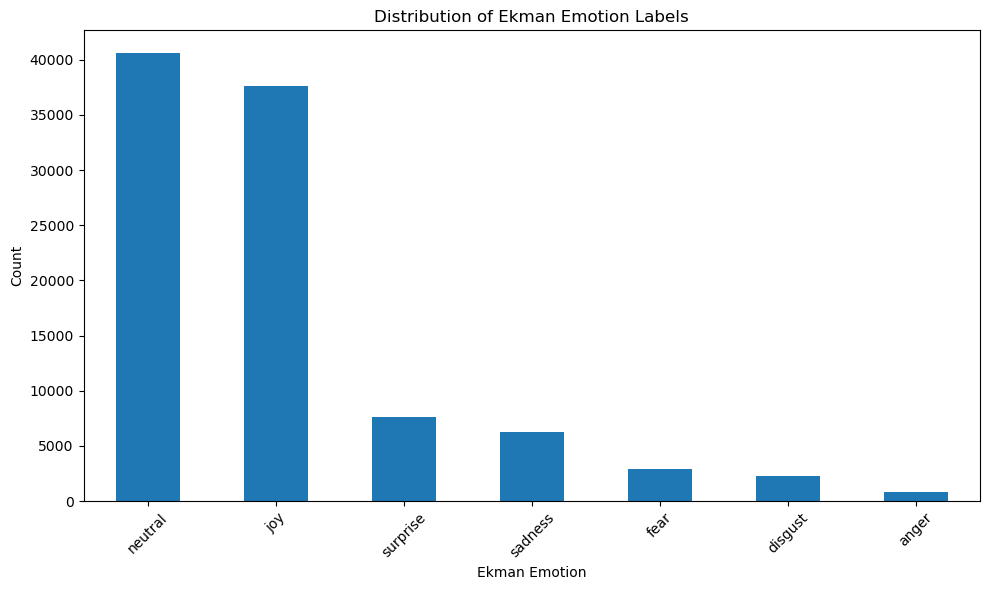

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Flatten the list of lists into one big list
all_ekman = [emotion for sublist in df_goemotion_ekman['ekman_emotions'] for emotion in sublist]

# Create counts
emotion_counts = pd.Series(all_ekman).value_counts()

# Plot
plt.figure(figsize=(10, 6))
emotion_counts.plot(kind='bar')
plt.xlabel('Ekman Emotion')
plt.ylabel('Count')
plt.title('Distribution of Ekman Emotion Labels')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [13]:
all_ekman = [emotion for sublist in df_goemotion_ekman['ekman_emotions'] for emotion in sublist]
emotion_counts = pd.Series(all_ekman).value_counts()

print(emotion_counts)


neutral     40630
joy         37595
surprise     7634
sadness      6238
fear         2914
disgust      2310
anger         871
Name: count, dtype: int64


In [16]:
df_goemotion_ekman.to_csv(r'C:\Users\akifk\Data Science Research Project B\Data\reddit_beyondblue_combined\reddit_beyondblue_combined_goEmotion_ekman.csv', index=False, encoding='utf-8')